### AOS duration test
performed on 3/6/20, each csv script lasted 62 minutes. We repeated 4 times.

In [1]:
from openpyxl import load_workbook

from astropy.time import Time
from datetime import timedelta, datetime
from lsst_efd_client import EfdClient

import matplotlib.pyplot as plt
import scipy.io
import numpy as np
import pandas as pd
plt.jet()

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters();

In [2]:
client = EfdClient('summit_efd')
csc_index = 1

### The test lasted about 4 hours. Look at the entire data set to make sure we have everything.
* We put on 
    * bm1 positive for 37s, then 
    * bm3 positive for 37s, then 
    * bm5 positive for 37s, then 
    * bm7 positive for 37s, then 
    * bm9 positive for 37s, then 
    * go back to bm1
* so each cycle took 5*37s, 
* 5 x 37 x 20 = 3700s = 61.7 minutes. Each script ran 62 minutes = 20 cycles
* we repeated 4 times. total was 80 cycles.

In [6]:
start = Time('2020-03-06T14:30:00') #this is UTC
end = Time('2020-03-06T18:42:00') 

In [7]:
df = await client.select_time_series('lsst.sal.MTM2.axialForcesMeasured', '*', 
                                     (start-timedelta(seconds=37)).tai, (end-timedelta(seconds=37)).tai, csc_index)

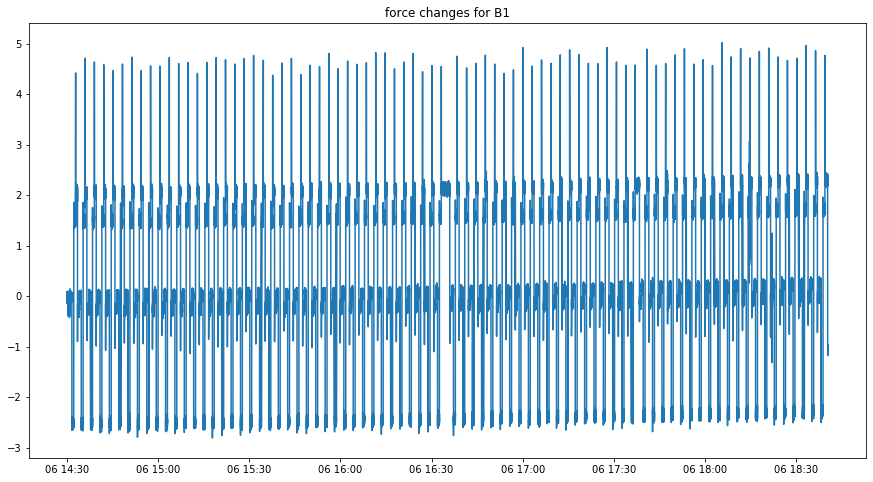

In [8]:
fig, ax = plt.subplots(figsize=(15,8))
for i in range(1):
    plt.plot(pd.to_datetime(df.private_sndStamp, unit='s'), df['axialForceMeasured%d'%i]-df['axialForceMeasured%d'%i][0])
#plt.title('force changes for first 3 actuators (B1,B2,B3)');
plt.title('force changes for B1');

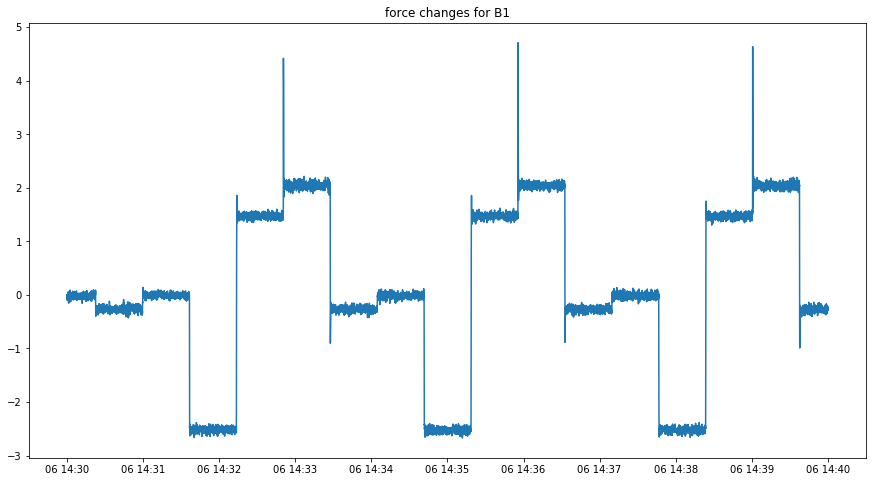

In [15]:
fig, ax = plt.subplots(figsize=(15,8))
for i in range(1):
    plt.plot(pd.to_datetime(df.private_sndStamp[:12000], unit='s'), 
             df['axialForceMeasured%d'%i][:12000]-df['axialForceMeasured%d'%i][0])
plt.title('force changes for B1');

### How are we going to identify the timestamps we started each round (repeat)?
We will simply look at force on B1. Each time it goes below -2N, it is a new cycle. A cycle = 5 x 37s

493
4194
7894


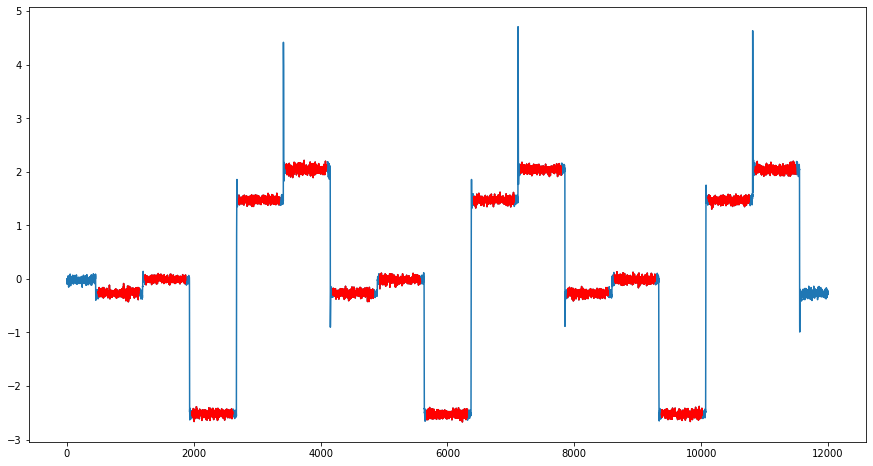

In [54]:
aa = np.array(df.axialForceMeasured0-df.axialForceMeasured0[0])
fig, ax = plt.subplots(figsize=(15,8))
#plt.plot(pd.to_datetime(df.private_sndStamp, unit='s'), aa )
plt.plot(np.arange(12000),df.axialForceMeasured0[:12000]-df.axialForceMeasured0[0])
for ic in range(3):
    base = np.argmax(aa<-2)+40-37*2*20  #find 3rd bm, then walk back to 1st (1st/2nd can be confused with noise)
    print(base)
    for i in range(5):
        idx = np.arange(base+i*37*20, base+i*37*20+20*32)  #32s = 15s+2s+15s (should have made 37 into 39, it is OK)
        plt.plot(idx, aa[idx], 'r')
    aa[:(base+37*20*4)] = 0

### Build an array to store the data we need.

In [18]:
bm = np.zeros((5, 78, 81))
#1st dimension: bending mode
#2nd : actuator (including tangent links)
#3rd, cycle (applied forces, then cycle#1, #2, and #3... #80

#### Fill in the applied forces

In [55]:
bmIn = np.loadtxt('../github/data/M2_1um_72_force.txt')
for i in range(5):
    scalef = 1./2
    bm[i,:72,0] = bmIn[:,(2*i)+3]*scalef    

#### Fill in the measured forces
* The average of 20 x 32 data points (32s) becomes one element in the above array.

In [57]:
dft = await client.select_time_series('lsst.sal.MTM2.tangentForcesMeasured', '*', 
                                     (start-timedelta(seconds=37)).tai, (end-timedelta(seconds=37)).tai, csc_index)

In [69]:
aa = np.array(df.axialForceMeasured0-df.axialForceMeasured0[0])
for iround in range(80):
    base = np.argmax(aa<-2)+40-37*2*20  #find 3rd bm, then walk back to 1st (1st/2nd can be confused with noise)
    assert base>0
    for i in range(5):     
        idx = np.arange(base+i*37*20, base+i*37*20+20*32)  #32s = 15s+2s+15s (should have made 37 into 39, it is OK)
        for iact in range(78):
            if iact<72:
                bm[i,iact,iround+1] = np.mean(np.array(df['axialForceMeasured%d'%iact][idx])) - \
                                           np.array(df['axialForceMeasured%d'%iact][0])
            else:
                bm[i,iact,iround+1] = np.mean(np.array(dft['tangentLink%dDegForceMeasured'%((iact-72)*60)][idx])-
                                           np.array(dft['tangentLink%dDegForceMeasured'%((iact-72)*60)][idx-100]))
            if abs(bm[i,iact,iround+1] - bm[i,iact, 0])>2:
                errorS = '=============='
            else:
                errorS =''
            print('bm%2d, act#%2d, round%d, idx[0] = %.0f, force = %.2fN/%.2fN, %s'%(
                2*i+1,iact+1, iround+1, idx[0], 
                bm[i,iact,iround+1],bm[i,iact, 0], errorS))

bm 1, act# 1, round1, idx[0] = 493, force = -0.26N/-0.25N, 
bm 1, act# 2, round1, idx[0] = 493, force = -0.23N/-0.26N, 
bm 1, act# 3, round1, idx[0] = 493, force = -0.15N/-0.21N, 
bm 1, act# 4, round1, idx[0] = 493, force = -0.16N/-0.13N, 
bm 1, act# 5, round1, idx[0] = 493, force = -0.10N/-0.03N, 
bm 1, act# 6, round1, idx[0] = 493, force = 0.09N/0.08N, 
bm 1, act# 7, round1, idx[0] = 493, force = 0.21N/0.17N, 
bm 1, act# 8, round1, idx[0] = 493, force = 0.24N/0.24N, 
bm 1, act# 9, round1, idx[0] = 493, force = 0.33N/0.26N, 
bm 1, act#10, round1, idx[0] = 493, force = 0.22N/0.24N, 
bm 1, act#11, round1, idx[0] = 493, force = 0.09N/0.18N, 
bm 1, act#12, round1, idx[0] = 493, force = 0.10N/0.08N, 
bm 1, act#13, round1, idx[0] = 493, force = 0.02N/-0.02N, 
bm 1, act#14, round1, idx[0] = 493, force = -0.20N/-0.13N, 
bm 1, act#15, round1, idx[0] = 493, force = -0.18N/-0.21N, 
bm 1, act#16, round1, idx[0] = 493, force = -0.22N/-0.25N, 
bm 1, act#17, round1, idx[0] = 493, force = -0.28N/-0.2

bm 3, act#24, round2, idx[0] = 1233, force = 1.80N/1.85N, 
bm 3, act#25, round2, idx[0] = 1233, force = 1.16N/1.14N, 
bm 3, act#26, round2, idx[0] = 1233, force = -0.03N/-0.00N, 
bm 3, act#27, round2, idx[0] = 1233, force = -1.10N/-1.14N, 
bm 3, act#28, round2, idx[0] = 1233, force = -1.89N/-1.85N, 
bm 3, act#29, round2, idx[0] = 1233, force = -1.82N/-1.85N, 
bm 3, act#30, round2, idx[0] = 1233, force = -1.05N/-1.14N, 
bm 3, act#31, round2, idx[0] = 1233, force = 0.51N/0.49N, 
bm 3, act#32, round2, idx[0] = 1233, force = 1.25N/1.20N, 
bm 3, act#33, round2, idx[0] = 1233, force = 1.14N/1.20N, 
bm 3, act#34, round2, idx[0] = 1233, force = 0.42N/0.49N, 
bm 3, act#35, round2, idx[0] = 1233, force = -0.51N/-0.49N, 
bm 3, act#36, round2, idx[0] = 1233, force = -1.24N/-1.20N, 
bm 3, act#37, round2, idx[0] = 1233, force = -1.27N/-1.20N, 
bm 3, act#38, round2, idx[0] = 1233, force = -0.53N/-0.49N, 
bm 3, act#39, round2, idx[0] = 1233, force = 0.47N/0.49N, 
bm 3, act#40, round2, idx[0] = 1233, f

bm 7, act#78, round3, idx[0] = 2713, force = 0.00N/0.00N, 
bm 9, act# 1, round3, idx[0] = 3453, force = 2.04N/2.05N, 
bm 9, act# 2, round3, idx[0] = 3453, force = -3.58N/-3.61N, 
bm 9, act# 3, round3, idx[0] = 3453, force = -6.86N/-6.92N, 
bm 9, act# 4, round3, idx[0] = 3453, force = -5.64N/-5.62N, 
bm 9, act# 5, round3, idx[0] = 3453, force = -0.66N/-0.58N, 
bm 9, act# 6, round3, idx[0] = 3453, force = 4.79N/4.79N, 
bm 9, act# 7, round3, idx[0] = 3453, force = 7.08N/7.06N, 
bm 9, act# 8, round3, idx[0] = 3453, force = 4.61N/4.64N, 
bm 9, act# 9, round3, idx[0] = 3453, force = -0.82N/-0.88N, 
bm 9, act#10, round3, idx[0] = 3453, force = -5.85N/-5.80N, 
bm 9, act#11, round3, idx[0] = 3453, force = -6.94N/-6.84N, 
bm 9, act#12, round3, idx[0] = 3453, force = -3.43N/-3.44N, 
bm 9, act#13, round3, idx[0] = 3453, force = 2.30N/2.28N, 
bm 9, act#14, round3, idx[0] = 3453, force = 6.42N/6.50N, 
bm 9, act#15, round3, idx[0] = 3453, force = 6.40N/6.38N, 
bm 9, act#16, round3, idx[0] = 3453, for

bm 3, act#75, round5, idx[0] = 1233, force = 0.00N/0.00N, 
bm 3, act#76, round5, idx[0] = 1233, force = 0.00N/0.00N, 
bm 3, act#77, round5, idx[0] = 1233, force = 0.01N/0.00N, 
bm 3, act#78, round5, idx[0] = 1233, force = -0.01N/0.00N, 
bm 5, act# 1, round5, idx[0] = 1973, force = -2.52N/-2.51N, 
bm 5, act# 2, round5, idx[0] = 1973, force = -2.47N/-2.50N, 
bm 5, act# 3, round5, idx[0] = 1973, force = -2.43N/-2.49N, 
bm 5, act# 4, round5, idx[0] = 1973, force = -2.48N/-2.47N, 
bm 5, act# 5, round5, idx[0] = 1973, force = -2.52N/-2.45N, 
bm 5, act# 6, round5, idx[0] = 1973, force = -2.45N/-2.46N, 
bm 5, act# 7, round5, idx[0] = 1973, force = -2.41N/-2.45N, 
bm 5, act# 8, round5, idx[0] = 1973, force = -2.47N/-2.47N, 
bm 5, act# 9, round5, idx[0] = 1973, force = -2.41N/-2.49N, 
bm 5, act#10, round5, idx[0] = 1973, force = -2.53N/-2.50N, 
bm 5, act#11, round5, idx[0] = 1973, force = -2.60N/-2.51N, 
bm 5, act#12, round5, idx[0] = 1973, force = -2.48N/-2.50N, 
bm 5, act#13, round5, idx[0] = 

bm 9, act#53, round6, idx[0] = 3453, force = 4.15N/4.13N, 
bm 9, act#54, round6, idx[0] = 3453, force = 3.12N/3.15N, 
bm 9, act#55, round6, idx[0] = 3453, force = 0.69N/0.72N, 
bm 9, act#56, round6, idx[0] = 3453, force = -2.21N/-2.16N, 
bm 9, act#57, round6, idx[0] = 3453, force = -1.49N/-1.45N, 
bm 9, act#58, round6, idx[0] = 3453, force = 1.64N/1.67N, 
bm 9, act#59, round6, idx[0] = 3453, force = 2.04N/2.05N, 
bm 9, act#60, round6, idx[0] = 3453, force = -1.01N/-0.96N, 
bm 9, act#61, round6, idx[0] = 3453, force = -2.38N/-2.39N, 
bm 9, act#62, round6, idx[0] = 3453, force = 0.12N/0.12N, 
bm 9, act#63, round6, idx[0] = 3453, force = 2.39N/2.42N, 
bm 9, act#64, round6, idx[0] = 3453, force = 0.70N/0.72N, 
bm 9, act#65, round6, idx[0] = 3453, force = -2.12N/-2.16N, 
bm 9, act#66, round6, idx[0] = 3453, force = -1.45N/-1.45N, 
bm 9, act#67, round6, idx[0] = 3453, force = 1.70N/1.67N, 
bm 9, act#68, round6, idx[0] = 3453, force = 2.01N/2.05N, 
bm 9, act#69, round6, idx[0] = 3453, force =

bm 5, act#13, round8, idx[0] = 1973, force = -2.45N/-2.49N, 
bm 5, act#14, round8, idx[0] = 1973, force = -2.53N/-2.47N, 
bm 5, act#15, round8, idx[0] = 1973, force = -2.42N/-2.45N, 
bm 5, act#16, round8, idx[0] = 1973, force = -2.42N/-2.46N, 
bm 5, act#17, round8, idx[0] = 1973, force = -2.48N/-2.45N, 
bm 5, act#18, round8, idx[0] = 1973, force = -2.43N/-2.47N, 
bm 5, act#19, round8, idx[0] = 1973, force = -2.49N/-2.49N, 
bm 5, act#20, round8, idx[0] = 1973, force = -2.49N/-2.50N, 
bm 5, act#21, round8, idx[0] = 1973, force = -2.52N/-2.51N, 
bm 5, act#22, round8, idx[0] = 1973, force = -2.48N/-2.50N, 
bm 5, act#23, round8, idx[0] = 1973, force = -2.47N/-2.49N, 
bm 5, act#24, round8, idx[0] = 1973, force = -2.51N/-2.47N, 
bm 5, act#25, round8, idx[0] = 1973, force = -2.43N/-2.45N, 
bm 5, act#26, round8, idx[0] = 1973, force = -2.49N/-2.46N, 
bm 5, act#27, round8, idx[0] = 1973, force = -2.40N/-2.45N, 
bm 5, act#28, round8, idx[0] = 1973, force = -2.50N/-2.47N, 
bm 5, act#29, round8, id

bm 1, act# 1, round10, idx[0] = 493, force = -0.26N/-0.25N, 
bm 1, act# 2, round10, idx[0] = 493, force = -0.23N/-0.26N, 
bm 1, act# 3, round10, idx[0] = 493, force = -0.15N/-0.21N, 
bm 1, act# 4, round10, idx[0] = 493, force = -0.16N/-0.13N, 
bm 1, act# 5, round10, idx[0] = 493, force = -0.10N/-0.03N, 
bm 1, act# 6, round10, idx[0] = 493, force = 0.09N/0.08N, 
bm 1, act# 7, round10, idx[0] = 493, force = 0.21N/0.17N, 
bm 1, act# 8, round10, idx[0] = 493, force = 0.24N/0.24N, 
bm 1, act# 9, round10, idx[0] = 493, force = 0.33N/0.26N, 
bm 1, act#10, round10, idx[0] = 493, force = 0.22N/0.24N, 
bm 1, act#11, round10, idx[0] = 493, force = 0.09N/0.18N, 
bm 1, act#12, round10, idx[0] = 493, force = 0.10N/0.08N, 
bm 1, act#13, round10, idx[0] = 493, force = 0.02N/-0.02N, 
bm 1, act#14, round10, idx[0] = 493, force = -0.20N/-0.13N, 
bm 1, act#15, round10, idx[0] = 493, force = -0.18N/-0.21N, 
bm 1, act#16, round10, idx[0] = 493, force = -0.22N/-0.25N, 
bm 1, act#17, round10, idx[0] = 493, fo

bm 5, act#61, round11, idx[0] = 1973, force = 3.38N/3.36N, 
bm 5, act#62, round11, idx[0] = 1973, force = 3.39N/3.38N, 
bm 5, act#63, round11, idx[0] = 1973, force = 3.38N/3.40N, 
bm 5, act#64, round11, idx[0] = 1973, force = 3.39N/3.40N, 
bm 5, act#65, round11, idx[0] = 1973, force = 3.45N/3.40N, 
bm 5, act#66, round11, idx[0] = 1973, force = 3.39N/3.38N, 
bm 5, act#67, round11, idx[0] = 1973, force = 3.39N/3.36N, 
bm 5, act#68, round11, idx[0] = 1973, force = 3.34N/3.38N, 
bm 5, act#69, round11, idx[0] = 1973, force = 3.40N/3.40N, 
bm 5, act#70, round11, idx[0] = 1973, force = 3.41N/3.40N, 
bm 5, act#71, round11, idx[0] = 1973, force = 3.40N/3.40N, 
bm 5, act#72, round11, idx[0] = 1973, force = 3.16N/3.38N, 
bm 5, act#73, round11, idx[0] = 1973, force = 0.01N/0.00N, 
bm 5, act#74, round11, idx[0] = 1973, force = -0.01N/0.00N, 
bm 5, act#75, round11, idx[0] = 1973, force = -0.01N/0.00N, 
bm 5, act#76, round11, idx[0] = 1973, force = -0.01N/0.00N, 
bm 5, act#77, round11, idx[0] = 1973,

bm 1, act#47, round13, idx[0] = 493, force = 0.13N/0.10N, 
bm 1, act#48, round13, idx[0] = 493, force = 0.15N/0.17N, 
bm 1, act#49, round13, idx[0] = 493, force = 0.20N/0.19N, 
bm 1, act#50, round13, idx[0] = 493, force = 0.21N/0.16N, 
bm 1, act#51, round13, idx[0] = 493, force = 0.07N/0.09N, 
bm 1, act#52, round13, idx[0] = 493, force = 0.01N/-0.01N, 
bm 1, act#53, round13, idx[0] = 493, force = -0.10N/-0.10N, 
bm 1, act#54, round13, idx[0] = 493, force = -0.21N/-0.17N, 
bm 1, act#55, round13, idx[0] = 493, force = -0.16N/-0.13N, 
bm 1, act#56, round13, idx[0] = 493, force = -0.16N/-0.12N, 
bm 1, act#57, round13, idx[0] = 493, force = -0.08N/-0.05N, 
bm 1, act#58, round13, idx[0] = 493, force = 0.01N/0.04N, 
bm 1, act#59, round13, idx[0] = 493, force = 0.11N/0.11N, 
bm 1, act#60, round13, idx[0] = 493, force = 0.09N/0.13N, 
bm 1, act#61, round13, idx[0] = 493, force = 0.11N/0.09N, 
bm 1, act#62, round13, idx[0] = 493, force = 0.03N/0.01N, 
bm 1, act#63, round13, idx[0] = 493, force = 

bm 7, act#47, round14, idx[0] = 2713, force = -1.64N/-1.68N, 
bm 7, act#48, round14, idx[0] = 2713, force = -2.02N/-2.01N, 
bm 7, act#49, round14, idx[0] = 2713, force = -2.19N/-2.20N, 
bm 7, act#50, round14, idx[0] = 2713, force = -2.20N/-2.24N, 
bm 7, act#51, round14, idx[0] = 2713, force = -2.15N/-2.13N, 
bm 7, act#52, round14, idx[0] = 2713, force = -1.86N/-1.88N, 
bm 7, act#53, round14, idx[0] = 2713, force = -1.49N/-1.50N, 
bm 7, act#54, round14, idx[0] = 2713, force = -1.05N/-1.01N, 
bm 7, act#55, round14, idx[0] = 2713, force = -2.74N/-2.71N, 
bm 7, act#56, round14, idx[0] = 2713, force = 0.08N/0.12N, 
bm 7, act#57, round14, idx[0] = 2713, force = 2.89N/2.92N, 
bm 7, act#58, round14, idx[0] = 2713, force = 5.35N/5.37N, 
bm 7, act#59, round14, idx[0] = 2713, force = 7.21N/7.21N, 
bm 7, act#60, round14, idx[0] = 2713, force = 8.11N/8.15N, 
bm 7, act#61, round14, idx[0] = 2713, force = 8.11N/8.09N, 
bm 7, act#62, round14, idx[0] = 2713, force = 7.11N/7.09N, 
bm 7, act#63, round14,

bm 3, act#36, round16, idx[0] = 1233, force = -1.24N/-1.20N, 
bm 3, act#37, round16, idx[0] = 1233, force = -1.27N/-1.20N, 
bm 3, act#38, round16, idx[0] = 1233, force = -0.53N/-0.49N, 
bm 3, act#39, round16, idx[0] = 1233, force = 0.47N/0.49N, 
bm 3, act#40, round16, idx[0] = 1233, force = 1.23N/1.20N, 
bm 3, act#41, round16, idx[0] = 1233, force = 1.23N/1.20N, 
bm 3, act#42, round16, idx[0] = 1233, force = 0.51N/0.49N, 
bm 3, act#43, round16, idx[0] = 1233, force = -0.56N/-0.49N, 
bm 3, act#44, round16, idx[0] = 1233, force = -1.20N/-1.20N, 
bm 3, act#45, round16, idx[0] = 1233, force = -1.20N/-1.20N, 
bm 3, act#46, round16, idx[0] = 1233, force = -0.53N/-0.49N, 
bm 3, act#47, round16, idx[0] = 1233, force = 0.53N/0.49N, 
bm 3, act#48, round16, idx[0] = 1233, force = 1.18N/1.20N, 
bm 3, act#49, round16, idx[0] = 1233, force = 1.21N/1.20N, 
bm 3, act#50, round16, idx[0] = 1233, force = 0.54N/0.49N, 
bm 3, act#51, round16, idx[0] = 1233, force = -0.50N/-0.49N, 
bm 3, act#52, round16, i

bm 7, act#76, round17, idx[0] = 2713, force = 0.01N/0.00N, 
bm 7, act#77, round17, idx[0] = 2713, force = 0.00N/0.00N, 
bm 7, act#78, round17, idx[0] = 2713, force = 0.00N/0.00N, 
bm 9, act# 1, round17, idx[0] = 3453, force = 2.04N/2.05N, 
bm 9, act# 2, round17, idx[0] = 3453, force = -3.58N/-3.61N, 
bm 9, act# 3, round17, idx[0] = 3453, force = -6.86N/-6.92N, 
bm 9, act# 4, round17, idx[0] = 3453, force = -5.64N/-5.62N, 
bm 9, act# 5, round17, idx[0] = 3453, force = -0.66N/-0.58N, 
bm 9, act# 6, round17, idx[0] = 3453, force = 4.79N/4.79N, 
bm 9, act# 7, round17, idx[0] = 3453, force = 7.08N/7.06N, 
bm 9, act# 8, round17, idx[0] = 3453, force = 4.61N/4.64N, 
bm 9, act# 9, round17, idx[0] = 3453, force = -0.82N/-0.88N, 
bm 9, act#10, round17, idx[0] = 3453, force = -5.85N/-5.80N, 
bm 9, act#11, round17, idx[0] = 3453, force = -6.94N/-6.84N, 
bm 9, act#12, round17, idx[0] = 3453, force = -3.43N/-3.44N, 
bm 9, act#13, round17, idx[0] = 3453, force = 2.30N/2.28N, 
bm 9, act#14, round17, i

bm 3, act#48, round19, idx[0] = 1233, force = 1.18N/1.20N, 
bm 3, act#49, round19, idx[0] = 1233, force = 1.21N/1.20N, 
bm 3, act#50, round19, idx[0] = 1233, force = 0.54N/0.49N, 
bm 3, act#51, round19, idx[0] = 1233, force = -0.50N/-0.49N, 
bm 3, act#52, round19, idx[0] = 1233, force = -1.17N/-1.20N, 
bm 3, act#53, round19, idx[0] = 1233, force = -1.18N/-1.20N, 
bm 3, act#54, round19, idx[0] = 1233, force = -0.54N/-0.49N, 
bm 3, act#55, round19, idx[0] = 1233, force = -0.02N/0.00N, 
bm 3, act#56, round19, idx[0] = 1233, force = 0.66N/0.70N, 
bm 3, act#57, round19, idx[0] = 1233, force = 0.67N/0.70N, 
bm 3, act#58, round19, idx[0] = 1233, force = -0.03N/-0.00N, 
bm 3, act#59, round19, idx[0] = 1233, force = -0.71N/-0.70N, 
bm 3, act#60, round19, idx[0] = 1233, force = -0.75N/-0.70N, 
bm 3, act#61, round19, idx[0] = 1233, force = 0.02N/0.00N, 
bm 3, act#62, round19, idx[0] = 1233, force = 0.72N/0.70N, 
bm 3, act#63, round19, idx[0] = 1233, force = 0.68N/0.70N, 
bm 3, act#64, round19, id

bm 9, act#20, round20, idx[0] = 3453, force = -0.56N/-0.58N, 
bm 9, act#21, round20, idx[0] = 3453, force = 4.79N/4.79N, 
bm 9, act#22, round20, idx[0] = 3453, force = 7.08N/7.06N, 
bm 9, act#23, round20, idx[0] = 3453, force = 4.66N/4.64N, 
bm 9, act#24, round20, idx[0] = 3453, force = -0.92N/-0.88N, 
bm 9, act#25, round20, idx[0] = 3453, force = -5.77N/-5.80N, 
bm 9, act#26, round20, idx[0] = 3453, force = -6.85N/-6.84N, 
bm 9, act#27, round20, idx[0] = 3453, force = -3.40N/-3.44N, 
bm 9, act#28, round20, idx[0] = 3453, force = 2.26N/2.28N, 
bm 9, act#29, round20, idx[0] = 3453, force = 6.53N/6.50N, 
bm 9, act#30, round20, idx[0] = 3453, force = 6.48N/6.38N, 
bm 9, act#31, round20, idx[0] = 3453, force = -0.95N/-0.96N, 
bm 9, act#32, round20, idx[0] = 3453, force = -4.07N/-4.12N, 
bm 9, act#33, round20, idx[0] = 3453, force = -3.20N/-3.14N, 
bm 9, act#34, round20, idx[0] = 3453, force = 0.90N/0.98N, 
bm 9, act#35, round20, idx[0] = 3453, force = 4.09N/4.13N, 
bm 9, act#36, round20, i

bm 3, act#69, round22, idx[0] = 1233, force = 0.70N/0.70N, 
bm 3, act#70, round22, idx[0] = 1233, force = -0.00N/-0.00N, 
bm 3, act#71, round22, idx[0] = 1233, force = -0.71N/-0.70N, 
bm 3, act#72, round22, idx[0] = 1233, force = -0.92N/-0.70N, 
bm 3, act#73, round22, idx[0] = 1233, force = -0.01N/0.00N, 
bm 3, act#74, round22, idx[0] = 1233, force = 0.00N/0.00N, 
bm 3, act#75, round22, idx[0] = 1233, force = 0.00N/0.00N, 
bm 3, act#76, round22, idx[0] = 1233, force = 0.00N/0.00N, 
bm 3, act#77, round22, idx[0] = 1233, force = 0.01N/0.00N, 
bm 3, act#78, round22, idx[0] = 1233, force = -0.01N/0.00N, 
bm 5, act# 1, round22, idx[0] = 1973, force = -2.52N/-2.51N, 
bm 5, act# 2, round22, idx[0] = 1973, force = -2.47N/-2.50N, 
bm 5, act# 3, round22, idx[0] = 1973, force = -2.43N/-2.49N, 
bm 5, act# 4, round22, idx[0] = 1973, force = -2.48N/-2.47N, 
bm 5, act# 5, round22, idx[0] = 1973, force = -2.52N/-2.45N, 
bm 5, act# 6, round22, idx[0] = 1973, force = -2.45N/-2.46N, 
bm 5, act# 7, round2

bm 9, act#42, round23, idx[0] = 3453, force = 3.16N/3.15N, 
bm 9, act#43, round23, idx[0] = 3453, force = -1.03N/-0.96N, 
bm 9, act#44, round23, idx[0] = 3453, force = -4.13N/-4.12N, 
bm 9, act#45, round23, idx[0] = 3453, force = -3.14N/-3.14N, 
bm 9, act#46, round23, idx[0] = 3453, force = 0.96N/0.98N, 
bm 9, act#47, round23, idx[0] = 3453, force = 4.17N/4.13N, 
bm 9, act#48, round23, idx[0] = 3453, force = 3.15N/3.16N, 
bm 9, act#49, round23, idx[0] = 3453, force = -0.96N/-0.98N, 
bm 9, act#50, round23, idx[0] = 3453, force = -4.07N/-4.13N, 
bm 9, act#51, round23, idx[0] = 3453, force = -3.15N/-3.16N, 
bm 9, act#52, round23, idx[0] = 3453, force = 1.00N/0.96N, 
bm 9, act#53, round23, idx[0] = 3453, force = 4.15N/4.13N, 
bm 9, act#54, round23, idx[0] = 3453, force = 3.12N/3.15N, 
bm 9, act#55, round23, idx[0] = 3453, force = 0.69N/0.72N, 
bm 9, act#56, round23, idx[0] = 3453, force = -2.21N/-2.16N, 
bm 9, act#57, round23, idx[0] = 3453, force = -1.49N/-1.45N, 
bm 9, act#58, round23, i

bm 5, act#12, round25, idx[0] = 1973, force = -2.48N/-2.50N, 
bm 5, act#13, round25, idx[0] = 1973, force = -2.45N/-2.49N, 
bm 5, act#14, round25, idx[0] = 1973, force = -2.53N/-2.47N, 
bm 5, act#15, round25, idx[0] = 1973, force = -2.42N/-2.45N, 
bm 5, act#16, round25, idx[0] = 1973, force = -2.42N/-2.46N, 
bm 5, act#17, round25, idx[0] = 1973, force = -2.48N/-2.45N, 
bm 5, act#18, round25, idx[0] = 1973, force = -2.43N/-2.47N, 
bm 5, act#19, round25, idx[0] = 1973, force = -2.49N/-2.49N, 
bm 5, act#20, round25, idx[0] = 1973, force = -2.49N/-2.50N, 
bm 5, act#21, round25, idx[0] = 1973, force = -2.52N/-2.51N, 
bm 5, act#22, round25, idx[0] = 1973, force = -2.48N/-2.50N, 
bm 5, act#23, round25, idx[0] = 1973, force = -2.47N/-2.49N, 
bm 5, act#24, round25, idx[0] = 1973, force = -2.51N/-2.47N, 
bm 5, act#25, round25, idx[0] = 1973, force = -2.43N/-2.45N, 
bm 5, act#26, round25, idx[0] = 1973, force = -2.49N/-2.46N, 
bm 5, act#27, round25, idx[0] = 1973, force = -2.40N/-2.45N, 
bm 5, ac

bm 9, act#75, round26, idx[0] = 3453, force = -0.01N/0.00N, 
bm 9, act#76, round26, idx[0] = 3453, force = 0.00N/0.00N, 
bm 9, act#77, round26, idx[0] = 3453, force = 0.01N/0.00N, 
bm 9, act#78, round26, idx[0] = 3453, force = 0.03N/0.00N, 
bm 1, act# 1, round27, idx[0] = 493, force = -0.26N/-0.25N, 
bm 1, act# 2, round27, idx[0] = 493, force = -0.23N/-0.26N, 
bm 1, act# 3, round27, idx[0] = 493, force = -0.15N/-0.21N, 
bm 1, act# 4, round27, idx[0] = 493, force = -0.16N/-0.13N, 
bm 1, act# 5, round27, idx[0] = 493, force = -0.10N/-0.03N, 
bm 1, act# 6, round27, idx[0] = 493, force = 0.09N/0.08N, 
bm 1, act# 7, round27, idx[0] = 493, force = 0.21N/0.17N, 
bm 1, act# 8, round27, idx[0] = 493, force = 0.24N/0.24N, 
bm 1, act# 9, round27, idx[0] = 493, force = 0.33N/0.26N, 
bm 1, act#10, round27, idx[0] = 493, force = 0.22N/0.24N, 
bm 1, act#11, round27, idx[0] = 493, force = 0.09N/0.18N, 
bm 1, act#12, round27, idx[0] = 493, force = 0.10N/0.08N, 
bm 1, act#13, round27, idx[0] = 493, forc

bm 5, act#15, round28, idx[0] = 1973, force = -2.42N/-2.45N, 
bm 5, act#16, round28, idx[0] = 1973, force = -2.42N/-2.46N, 
bm 5, act#17, round28, idx[0] = 1973, force = -2.48N/-2.45N, 
bm 5, act#18, round28, idx[0] = 1973, force = -2.43N/-2.47N, 
bm 5, act#19, round28, idx[0] = 1973, force = -2.49N/-2.49N, 
bm 5, act#20, round28, idx[0] = 1973, force = -2.49N/-2.50N, 
bm 5, act#21, round28, idx[0] = 1973, force = -2.52N/-2.51N, 
bm 5, act#22, round28, idx[0] = 1973, force = -2.48N/-2.50N, 
bm 5, act#23, round28, idx[0] = 1973, force = -2.47N/-2.49N, 
bm 5, act#24, round28, idx[0] = 1973, force = -2.51N/-2.47N, 
bm 5, act#25, round28, idx[0] = 1973, force = -2.43N/-2.45N, 
bm 5, act#26, round28, idx[0] = 1973, force = -2.49N/-2.46N, 
bm 5, act#27, round28, idx[0] = 1973, force = -2.40N/-2.45N, 
bm 5, act#28, round28, idx[0] = 1973, force = -2.50N/-2.47N, 
bm 5, act#29, round28, idx[0] = 1973, force = -2.46N/-2.49N, 
bm 5, act#30, round28, idx[0] = 1973, force = -2.41N/-2.50N, 
bm 5, ac

bm 9, act#61, round29, idx[0] = 3453, force = -2.38N/-2.39N, 
bm 9, act#62, round29, idx[0] = 3453, force = 0.12N/0.12N, 
bm 9, act#63, round29, idx[0] = 3453, force = 2.39N/2.42N, 
bm 9, act#64, round29, idx[0] = 3453, force = 0.70N/0.72N, 
bm 9, act#65, round29, idx[0] = 3453, force = -2.12N/-2.16N, 
bm 9, act#66, round29, idx[0] = 3453, force = -1.45N/-1.45N, 
bm 9, act#67, round29, idx[0] = 3453, force = 1.70N/1.67N, 
bm 9, act#68, round29, idx[0] = 3453, force = 2.01N/2.05N, 
bm 9, act#69, round29, idx[0] = 3453, force = -0.96N/-0.96N, 
bm 9, act#70, round29, idx[0] = 3453, force = -2.38N/-2.39N, 
bm 9, act#71, round29, idx[0] = 3453, force = 0.12N/0.12N, 
bm 9, act#72, round29, idx[0] = 3453, force = 2.20N/2.42N, 
bm 9, act#73, round29, idx[0] = 3453, force = 0.01N/0.00N, 
bm 9, act#74, round29, idx[0] = 3453, force = 0.00N/0.00N, 
bm 9, act#75, round29, idx[0] = 3453, force = -0.01N/0.00N, 
bm 9, act#76, round29, idx[0] = 3453, force = 0.00N/0.00N, 
bm 9, act#77, round29, idx[0]

bm 5, act#26, round31, idx[0] = 1973, force = -2.49N/-2.46N, 
bm 5, act#27, round31, idx[0] = 1973, force = -2.40N/-2.45N, 
bm 5, act#28, round31, idx[0] = 1973, force = -2.50N/-2.47N, 
bm 5, act#29, round31, idx[0] = 1973, force = -2.46N/-2.49N, 
bm 5, act#30, round31, idx[0] = 1973, force = -2.41N/-2.50N, 
bm 5, act#31, round31, idx[0] = 1973, force = 0.55N/0.53N, 
bm 5, act#32, round31, idx[0] = 1973, force = 0.60N/0.55N, 
bm 5, act#33, round31, idx[0] = 1973, force = 0.52N/0.57N, 
bm 5, act#34, round31, idx[0] = 1973, force = 0.51N/0.58N, 
bm 5, act#35, round31, idx[0] = 1973, force = 0.56N/0.58N, 
bm 5, act#36, round31, idx[0] = 1973, force = 0.52N/0.57N, 
bm 5, act#37, round31, idx[0] = 1973, force = 0.48N/0.55N, 
bm 5, act#38, round31, idx[0] = 1973, force = 0.50N/0.53N, 
bm 5, act#39, round31, idx[0] = 1973, force = 0.52N/0.53N, 
bm 5, act#40, round31, idx[0] = 1973, force = 0.58N/0.55N, 
bm 5, act#41, round31, idx[0] = 1973, force = 0.61N/0.57N, 
bm 5, act#42, round31, idx[0] 

bm 9, act#61, round32, idx[0] = 3453, force = -2.38N/-2.39N, 
bm 9, act#62, round32, idx[0] = 3453, force = 0.12N/0.12N, 
bm 9, act#63, round32, idx[0] = 3453, force = 2.39N/2.42N, 
bm 9, act#64, round32, idx[0] = 3453, force = 0.70N/0.72N, 
bm 9, act#65, round32, idx[0] = 3453, force = -2.12N/-2.16N, 
bm 9, act#66, round32, idx[0] = 3453, force = -1.45N/-1.45N, 
bm 9, act#67, round32, idx[0] = 3453, force = 1.70N/1.67N, 
bm 9, act#68, round32, idx[0] = 3453, force = 2.01N/2.05N, 
bm 9, act#69, round32, idx[0] = 3453, force = -0.96N/-0.96N, 
bm 9, act#70, round32, idx[0] = 3453, force = -2.38N/-2.39N, 
bm 9, act#71, round32, idx[0] = 3453, force = 0.12N/0.12N, 
bm 9, act#72, round32, idx[0] = 3453, force = 2.20N/2.42N, 
bm 9, act#73, round32, idx[0] = 3453, force = 0.01N/0.00N, 
bm 9, act#74, round32, idx[0] = 3453, force = 0.00N/0.00N, 
bm 9, act#75, round32, idx[0] = 3453, force = -0.01N/0.00N, 
bm 9, act#76, round32, idx[0] = 3453, force = 0.00N/0.00N, 
bm 9, act#77, round32, idx[0]

bm 5, act#18, round34, idx[0] = 1973, force = -2.43N/-2.47N, 
bm 5, act#19, round34, idx[0] = 1973, force = -2.49N/-2.49N, 
bm 5, act#20, round34, idx[0] = 1973, force = -2.49N/-2.50N, 
bm 5, act#21, round34, idx[0] = 1973, force = -2.52N/-2.51N, 
bm 5, act#22, round34, idx[0] = 1973, force = -2.48N/-2.50N, 
bm 5, act#23, round34, idx[0] = 1973, force = -2.47N/-2.49N, 
bm 5, act#24, round34, idx[0] = 1973, force = -2.51N/-2.47N, 
bm 5, act#25, round34, idx[0] = 1973, force = -2.43N/-2.45N, 
bm 5, act#26, round34, idx[0] = 1973, force = -2.49N/-2.46N, 
bm 5, act#27, round34, idx[0] = 1973, force = -2.40N/-2.45N, 
bm 5, act#28, round34, idx[0] = 1973, force = -2.50N/-2.47N, 
bm 5, act#29, round34, idx[0] = 1973, force = -2.46N/-2.49N, 
bm 5, act#30, round34, idx[0] = 1973, force = -2.41N/-2.50N, 
bm 5, act#31, round34, idx[0] = 1973, force = 0.55N/0.53N, 
bm 5, act#32, round34, idx[0] = 1973, force = 0.60N/0.55N, 
bm 5, act#33, round34, idx[0] = 1973, force = 0.52N/0.57N, 
bm 5, act#34, 

bm 9, act#55, round35, idx[0] = 3453, force = 0.69N/0.72N, 
bm 9, act#56, round35, idx[0] = 3453, force = -2.21N/-2.16N, 
bm 9, act#57, round35, idx[0] = 3453, force = -1.49N/-1.45N, 
bm 9, act#58, round35, idx[0] = 3453, force = 1.64N/1.67N, 
bm 9, act#59, round35, idx[0] = 3453, force = 2.04N/2.05N, 
bm 9, act#60, round35, idx[0] = 3453, force = -1.01N/-0.96N, 
bm 9, act#61, round35, idx[0] = 3453, force = -2.38N/-2.39N, 
bm 9, act#62, round35, idx[0] = 3453, force = 0.12N/0.12N, 
bm 9, act#63, round35, idx[0] = 3453, force = 2.39N/2.42N, 
bm 9, act#64, round35, idx[0] = 3453, force = 0.70N/0.72N, 
bm 9, act#65, round35, idx[0] = 3453, force = -2.12N/-2.16N, 
bm 9, act#66, round35, idx[0] = 3453, force = -1.45N/-1.45N, 
bm 9, act#67, round35, idx[0] = 3453, force = 1.70N/1.67N, 
bm 9, act#68, round35, idx[0] = 3453, force = 2.01N/2.05N, 
bm 9, act#69, round35, idx[0] = 3453, force = -0.96N/-0.96N, 
bm 9, act#70, round35, idx[0] = 3453, force = -2.38N/-2.39N, 
bm 9, act#71, round35, i

bm 5, act# 3, round37, idx[0] = 1973, force = -2.43N/-2.49N, 
bm 5, act# 4, round37, idx[0] = 1973, force = -2.48N/-2.47N, 
bm 5, act# 5, round37, idx[0] = 1973, force = -2.52N/-2.45N, 
bm 5, act# 6, round37, idx[0] = 1973, force = -2.45N/-2.46N, 
bm 5, act# 7, round37, idx[0] = 1973, force = -2.41N/-2.45N, 
bm 5, act# 8, round37, idx[0] = 1973, force = -2.47N/-2.47N, 
bm 5, act# 9, round37, idx[0] = 1973, force = -2.41N/-2.49N, 
bm 5, act#10, round37, idx[0] = 1973, force = -2.53N/-2.50N, 
bm 5, act#11, round37, idx[0] = 1973, force = -2.60N/-2.51N, 
bm 5, act#12, round37, idx[0] = 1973, force = -2.48N/-2.50N, 
bm 5, act#13, round37, idx[0] = 1973, force = -2.45N/-2.49N, 
bm 5, act#14, round37, idx[0] = 1973, force = -2.53N/-2.47N, 
bm 5, act#15, round37, idx[0] = 1973, force = -2.42N/-2.45N, 
bm 5, act#16, round37, idx[0] = 1973, force = -2.42N/-2.46N, 
bm 5, act#17, round37, idx[0] = 1973, force = -2.48N/-2.45N, 
bm 5, act#18, round37, idx[0] = 1973, force = -2.43N/-2.47N, 
bm 5, ac

bm 9, act#73, round38, idx[0] = 3453, force = 0.01N/0.00N, 
bm 9, act#74, round38, idx[0] = 3453, force = 0.00N/0.00N, 
bm 9, act#75, round38, idx[0] = 3453, force = -0.01N/0.00N, 
bm 9, act#76, round38, idx[0] = 3453, force = 0.00N/0.00N, 
bm 9, act#77, round38, idx[0] = 3453, force = 0.01N/0.00N, 
bm 9, act#78, round38, idx[0] = 3453, force = 0.03N/0.00N, 
bm 1, act# 1, round39, idx[0] = 493, force = -0.26N/-0.25N, 
bm 1, act# 2, round39, idx[0] = 493, force = -0.23N/-0.26N, 
bm 1, act# 3, round39, idx[0] = 493, force = -0.15N/-0.21N, 
bm 1, act# 4, round39, idx[0] = 493, force = -0.16N/-0.13N, 
bm 1, act# 5, round39, idx[0] = 493, force = -0.10N/-0.03N, 
bm 1, act# 6, round39, idx[0] = 493, force = 0.09N/0.08N, 
bm 1, act# 7, round39, idx[0] = 493, force = 0.21N/0.17N, 
bm 1, act# 8, round39, idx[0] = 493, force = 0.24N/0.24N, 
bm 1, act# 9, round39, idx[0] = 493, force = 0.33N/0.26N, 
bm 1, act#10, round39, idx[0] = 493, force = 0.22N/0.24N, 
bm 1, act#11, round39, idx[0] = 493, fo

bm 5, act#69, round40, idx[0] = 1973, force = 3.40N/3.40N, 
bm 5, act#70, round40, idx[0] = 1973, force = 3.41N/3.40N, 
bm 5, act#71, round40, idx[0] = 1973, force = 3.40N/3.40N, 
bm 5, act#72, round40, idx[0] = 1973, force = 3.16N/3.38N, 
bm 5, act#73, round40, idx[0] = 1973, force = 0.01N/0.00N, 
bm 5, act#74, round40, idx[0] = 1973, force = -0.01N/0.00N, 
bm 5, act#75, round40, idx[0] = 1973, force = -0.01N/0.00N, 
bm 5, act#76, round40, idx[0] = 1973, force = -0.01N/0.00N, 
bm 5, act#77, round40, idx[0] = 1973, force = -0.01N/0.00N, 
bm 5, act#78, round40, idx[0] = 1973, force = 0.00N/0.00N, 
bm 7, act# 1, round40, idx[0] = 2713, force = 1.47N/1.49N, 
bm 7, act# 2, round40, idx[0] = 2713, force = 0.59N/0.57N, 
bm 7, act# 3, round40, idx[0] = 2713, force = -0.33N/-0.38N, 
bm 7, act# 4, round40, idx[0] = 2713, force = -1.33N/-1.31N, 
bm 7, act# 5, round40, idx[0] = 2713, force = -2.24N/-2.17N, 
bm 7, act# 6, round40, idx[0] = 2713, force = -2.94N/-2.95N, 
bm 7, act# 7, round40, idx[0

bm 1, act#58, round42, idx[0] = 493, force = 0.01N/0.04N, 
bm 1, act#59, round42, idx[0] = 493, force = 0.11N/0.11N, 
bm 1, act#60, round42, idx[0] = 493, force = 0.09N/0.13N, 
bm 1, act#61, round42, idx[0] = 493, force = 0.11N/0.09N, 
bm 1, act#62, round42, idx[0] = 493, force = 0.03N/0.01N, 
bm 1, act#63, round42, idx[0] = 493, force = -0.09N/-0.08N, 
bm 1, act#64, round42, idx[0] = 493, force = -0.14N/-0.13N, 
bm 1, act#65, round42, idx[0] = 493, force = -0.06N/-0.12N, 
bm 1, act#66, round42, idx[0] = 493, force = -0.05N/-0.05N, 
bm 1, act#67, round42, idx[0] = 493, force = 0.06N/0.04N, 
bm 1, act#68, round42, idx[0] = 493, force = 0.07N/0.11N, 
bm 1, act#69, round42, idx[0] = 493, force = 0.12N/0.13N, 
bm 1, act#70, round42, idx[0] = 493, force = 0.08N/0.09N, 
bm 1, act#71, round42, idx[0] = 493, force = 0.00N/0.01N, 
bm 1, act#72, round42, idx[0] = 493, force = -0.30N/-0.08N, 
bm 1, act#73, round42, idx[0] = 493, force = -0.00N/0.00N, 
bm 1, act#74, round42, idx[0] = 493, force = 

bm 7, act#39, round43, idx[0] = 2713, force = 2.12N/2.13N, 
bm 7, act#40, round43, idx[0] = 2713, force = 1.92N/1.88N, 
bm 7, act#41, round43, idx[0] = 2713, force = 1.54N/1.50N, 
bm 7, act#42, round43, idx[0] = 2713, force = 1.03N/1.01N, 
bm 7, act#43, round43, idx[0] = 2713, force = 0.40N/0.46N, 
bm 7, act#44, round43, idx[0] = 2713, force = -0.14N/-0.13N, 
bm 7, act#45, round43, idx[0] = 2713, force = -0.70N/-0.70N, 
bm 7, act#46, round43, idx[0] = 2713, force = -1.26N/-1.23N, 
bm 7, act#47, round43, idx[0] = 2713, force = -1.64N/-1.68N, 
bm 7, act#48, round43, idx[0] = 2713, force = -2.02N/-2.01N, 
bm 7, act#49, round43, idx[0] = 2713, force = -2.19N/-2.20N, 
bm 7, act#50, round43, idx[0] = 2713, force = -2.20N/-2.24N, 
bm 7, act#51, round43, idx[0] = 2713, force = -2.15N/-2.13N, 
bm 7, act#52, round43, idx[0] = 2713, force = -1.86N/-1.88N, 
bm 7, act#53, round43, idx[0] = 2713, force = -1.49N/-1.50N, 
bm 7, act#54, round43, idx[0] = 2713, force = -1.05N/-1.01N, 
bm 7, act#55, roun

bm 3, act#28, round45, idx[0] = 1233, force = -1.89N/-1.85N, 
bm 3, act#29, round45, idx[0] = 1233, force = -1.82N/-1.85N, 
bm 3, act#30, round45, idx[0] = 1233, force = -1.05N/-1.14N, 
bm 3, act#31, round45, idx[0] = 1233, force = 0.51N/0.49N, 
bm 3, act#32, round45, idx[0] = 1233, force = 1.25N/1.20N, 
bm 3, act#33, round45, idx[0] = 1233, force = 1.14N/1.20N, 
bm 3, act#34, round45, idx[0] = 1233, force = 0.42N/0.49N, 
bm 3, act#35, round45, idx[0] = 1233, force = -0.51N/-0.49N, 
bm 3, act#36, round45, idx[0] = 1233, force = -1.24N/-1.20N, 
bm 3, act#37, round45, idx[0] = 1233, force = -1.27N/-1.20N, 
bm 3, act#38, round45, idx[0] = 1233, force = -0.53N/-0.49N, 
bm 3, act#39, round45, idx[0] = 1233, force = 0.47N/0.49N, 
bm 3, act#40, round45, idx[0] = 1233, force = 1.23N/1.20N, 
bm 3, act#41, round45, idx[0] = 1233, force = 1.23N/1.20N, 
bm 3, act#42, round45, idx[0] = 1233, force = 0.51N/0.49N, 
bm 3, act#43, round45, idx[0] = 1233, force = -0.56N/-0.49N, 
bm 3, act#44, round45, i

bm 7, act#64, round46, idx[0] = 2713, force = 2.71N/2.71N, 
bm 7, act#65, round46, idx[0] = 2713, force = -0.07N/-0.12N, 
bm 7, act#66, round46, idx[0] = 2713, force = -2.92N/-2.92N, 
bm 7, act#67, round46, idx[0] = 2713, force = -5.35N/-5.37N, 
bm 7, act#68, round46, idx[0] = 2713, force = -7.26N/-7.21N, 
bm 7, act#69, round46, idx[0] = 2713, force = -8.16N/-8.15N, 
bm 7, act#70, round46, idx[0] = 2713, force = -8.09N/-8.09N, 
bm 7, act#71, round46, idx[0] = 2713, force = -7.10N/-7.09N, 
bm 7, act#72, round46, idx[0] = 2713, force = -5.46N/-5.23N, 
bm 7, act#73, round46, idx[0] = 2713, force = 0.01N/0.00N, 
bm 7, act#74, round46, idx[0] = 2713, force = 0.02N/0.00N, 
bm 7, act#75, round46, idx[0] = 2713, force = 0.01N/0.00N, 
bm 7, act#76, round46, idx[0] = 2713, force = 0.01N/0.00N, 
bm 7, act#77, round46, idx[0] = 2713, force = 0.00N/0.00N, 
bm 7, act#78, round46, idx[0] = 2713, force = 0.00N/0.00N, 
bm 9, act# 1, round46, idx[0] = 3453, force = 2.04N/2.05N, 
bm 9, act# 2, round46, i

bm 3, act#47, round48, idx[0] = 1233, force = 0.53N/0.49N, 
bm 3, act#48, round48, idx[0] = 1233, force = 1.18N/1.20N, 
bm 3, act#49, round48, idx[0] = 1233, force = 1.21N/1.20N, 
bm 3, act#50, round48, idx[0] = 1233, force = 0.54N/0.49N, 
bm 3, act#51, round48, idx[0] = 1233, force = -0.50N/-0.49N, 
bm 3, act#52, round48, idx[0] = 1233, force = -1.17N/-1.20N, 
bm 3, act#53, round48, idx[0] = 1233, force = -1.18N/-1.20N, 
bm 3, act#54, round48, idx[0] = 1233, force = -0.54N/-0.49N, 
bm 3, act#55, round48, idx[0] = 1233, force = -0.02N/0.00N, 
bm 3, act#56, round48, idx[0] = 1233, force = 0.66N/0.70N, 
bm 3, act#57, round48, idx[0] = 1233, force = 0.67N/0.70N, 
bm 3, act#58, round48, idx[0] = 1233, force = -0.03N/-0.00N, 
bm 3, act#59, round48, idx[0] = 1233, force = -0.71N/-0.70N, 
bm 3, act#60, round48, idx[0] = 1233, force = -0.75N/-0.70N, 
bm 3, act#61, round48, idx[0] = 1233, force = 0.02N/0.00N, 
bm 3, act#62, round48, idx[0] = 1233, force = 0.72N/0.70N, 
bm 3, act#63, round48, id

bm 9, act#17, round49, idx[0] = 3453, force = -3.64N/-3.61N, 
bm 9, act#18, round49, idx[0] = 3453, force = -6.88N/-6.92N, 
bm 9, act#19, round49, idx[0] = 3453, force = -5.63N/-5.62N, 
bm 9, act#20, round49, idx[0] = 3453, force = -0.56N/-0.58N, 
bm 9, act#21, round49, idx[0] = 3453, force = 4.79N/4.79N, 
bm 9, act#22, round49, idx[0] = 3453, force = 7.08N/7.06N, 
bm 9, act#23, round49, idx[0] = 3453, force = 4.66N/4.64N, 
bm 9, act#24, round49, idx[0] = 3453, force = -0.92N/-0.88N, 
bm 9, act#25, round49, idx[0] = 3453, force = -5.77N/-5.80N, 
bm 9, act#26, round49, idx[0] = 3453, force = -6.85N/-6.84N, 
bm 9, act#27, round49, idx[0] = 3453, force = -3.40N/-3.44N, 
bm 9, act#28, round49, idx[0] = 3453, force = 2.26N/2.28N, 
bm 9, act#29, round49, idx[0] = 3453, force = 6.53N/6.50N, 
bm 9, act#30, round49, idx[0] = 3453, force = 6.48N/6.38N, 
bm 9, act#31, round49, idx[0] = 3453, force = -0.95N/-0.96N, 
bm 9, act#32, round49, idx[0] = 3453, force = -4.07N/-4.12N, 
bm 9, act#33, round4

bm 5, act#12, round51, idx[0] = 1973, force = -2.48N/-2.50N, 
bm 5, act#13, round51, idx[0] = 1973, force = -2.45N/-2.49N, 
bm 5, act#14, round51, idx[0] = 1973, force = -2.53N/-2.47N, 
bm 5, act#15, round51, idx[0] = 1973, force = -2.42N/-2.45N, 
bm 5, act#16, round51, idx[0] = 1973, force = -2.42N/-2.46N, 
bm 5, act#17, round51, idx[0] = 1973, force = -2.48N/-2.45N, 
bm 5, act#18, round51, idx[0] = 1973, force = -2.43N/-2.47N, 
bm 5, act#19, round51, idx[0] = 1973, force = -2.49N/-2.49N, 
bm 5, act#20, round51, idx[0] = 1973, force = -2.49N/-2.50N, 
bm 5, act#21, round51, idx[0] = 1973, force = -2.52N/-2.51N, 
bm 5, act#22, round51, idx[0] = 1973, force = -2.48N/-2.50N, 
bm 5, act#23, round51, idx[0] = 1973, force = -2.47N/-2.49N, 
bm 5, act#24, round51, idx[0] = 1973, force = -2.51N/-2.47N, 
bm 5, act#25, round51, idx[0] = 1973, force = -2.43N/-2.45N, 
bm 5, act#26, round51, idx[0] = 1973, force = -2.49N/-2.46N, 
bm 5, act#27, round51, idx[0] = 1973, force = -2.40N/-2.45N, 
bm 5, ac

bm 1, act#12, round53, idx[0] = 493, force = 0.10N/0.08N, 
bm 1, act#13, round53, idx[0] = 493, force = 0.02N/-0.02N, 
bm 1, act#14, round53, idx[0] = 493, force = -0.20N/-0.13N, 
bm 1, act#15, round53, idx[0] = 493, force = -0.18N/-0.21N, 
bm 1, act#16, round53, idx[0] = 493, force = -0.22N/-0.25N, 
bm 1, act#17, round53, idx[0] = 493, force = -0.28N/-0.26N, 
bm 1, act#18, round53, idx[0] = 493, force = -0.18N/-0.21N, 
bm 1, act#19, round53, idx[0] = 493, force = -0.14N/-0.13N, 
bm 1, act#20, round53, idx[0] = 493, force = -0.02N/-0.03N, 
bm 1, act#21, round53, idx[0] = 493, force = 0.07N/0.08N, 
bm 1, act#22, round53, idx[0] = 493, force = 0.20N/0.17N, 
bm 1, act#23, round53, idx[0] = 493, force = 0.25N/0.24N, 
bm 1, act#24, round53, idx[0] = 493, force = 0.22N/0.26N, 
bm 1, act#25, round53, idx[0] = 493, force = 0.25N/0.24N, 
bm 1, act#26, round53, idx[0] = 493, force = 0.15N/0.18N, 
bm 1, act#27, round53, idx[0] = 493, force = 0.12N/0.08N, 
bm 1, act#28, round53, idx[0] = 493, forc

bm 5, act#65, round54, idx[0] = 1973, force = 3.45N/3.40N, 
bm 5, act#66, round54, idx[0] = 1973, force = 3.39N/3.38N, 
bm 5, act#67, round54, idx[0] = 1973, force = 3.39N/3.36N, 
bm 5, act#68, round54, idx[0] = 1973, force = 3.34N/3.38N, 
bm 5, act#69, round54, idx[0] = 1973, force = 3.40N/3.40N, 
bm 5, act#70, round54, idx[0] = 1973, force = 3.41N/3.40N, 
bm 5, act#71, round54, idx[0] = 1973, force = 3.40N/3.40N, 
bm 5, act#72, round54, idx[0] = 1973, force = 3.16N/3.38N, 
bm 5, act#73, round54, idx[0] = 1973, force = 0.01N/0.00N, 
bm 5, act#74, round54, idx[0] = 1973, force = -0.01N/0.00N, 
bm 5, act#75, round54, idx[0] = 1973, force = -0.01N/0.00N, 
bm 5, act#76, round54, idx[0] = 1973, force = -0.01N/0.00N, 
bm 5, act#77, round54, idx[0] = 1973, force = -0.01N/0.00N, 
bm 5, act#78, round54, idx[0] = 1973, force = 0.00N/0.00N, 
bm 7, act# 1, round54, idx[0] = 2713, force = 1.47N/1.49N, 
bm 7, act# 2, round54, idx[0] = 2713, force = 0.59N/0.57N, 
bm 7, act# 3, round54, idx[0] = 2713

bm 1, act#42, round56, idx[0] = 493, force = -0.15N/-0.17N, 
bm 1, act#43, round56, idx[0] = 493, force = -0.25N/-0.19N, 
bm 1, act#44, round56, idx[0] = 493, force = -0.17N/-0.16N, 
bm 1, act#45, round56, idx[0] = 493, force = -0.09N/-0.09N, 
bm 1, act#46, round56, idx[0] = 493, force = -0.02N/0.01N, 
bm 1, act#47, round56, idx[0] = 493, force = 0.13N/0.10N, 
bm 1, act#48, round56, idx[0] = 493, force = 0.15N/0.17N, 
bm 1, act#49, round56, idx[0] = 493, force = 0.20N/0.19N, 
bm 1, act#50, round56, idx[0] = 493, force = 0.21N/0.16N, 
bm 1, act#51, round56, idx[0] = 493, force = 0.07N/0.09N, 
bm 1, act#52, round56, idx[0] = 493, force = 0.01N/-0.01N, 
bm 1, act#53, round56, idx[0] = 493, force = -0.10N/-0.10N, 
bm 1, act#54, round56, idx[0] = 493, force = -0.21N/-0.17N, 
bm 1, act#55, round56, idx[0] = 493, force = -0.16N/-0.13N, 
bm 1, act#56, round56, idx[0] = 493, force = -0.16N/-0.12N, 
bm 1, act#57, round56, idx[0] = 493, force = -0.08N/-0.05N, 
bm 1, act#58, round56, idx[0] = 493,

bm 7, act#20, round57, idx[0] = 2713, force = 2.19N/2.17N, 
bm 7, act#21, round57, idx[0] = 2713, force = 2.94N/2.95N, 
bm 7, act#22, round57, idx[0] = 2713, force = 3.62N/3.61N, 
bm 7, act#23, round57, idx[0] = 2713, force = 4.14N/4.13N, 
bm 7, act#24, round57, idx[0] = 2713, force = 4.38N/4.44N, 
bm 7, act#25, round57, idx[0] = 2713, force = 4.53N/4.52N, 
bm 7, act#26, round57, idx[0] = 2713, force = 4.40N/4.44N, 
bm 7, act#27, round57, idx[0] = 2713, force = 4.20N/4.17N, 
bm 7, act#28, round57, idx[0] = 2713, force = 3.70N/3.74N, 
bm 7, act#29, round57, idx[0] = 2713, force = 3.15N/3.13N, 
bm 7, act#30, round57, idx[0] = 2713, force = 2.43N/2.35N, 
bm 7, act#31, round57, idx[0] = 2713, force = -0.44N/-0.46N, 
bm 7, act#32, round57, idx[0] = 2713, force = 0.18N/0.13N, 
bm 7, act#33, round57, idx[0] = 2713, force = 0.65N/0.70N, 
bm 7, act#34, round57, idx[0] = 2713, force = 1.16N/1.23N, 
bm 7, act#35, round57, idx[0] = 2713, force = 1.65N/1.68N, 
bm 7, act#36, round57, idx[0] = 2713, 

bm 3, act#12, round59, idx[0] = 1233, force = 1.16N/1.14N, 
bm 3, act#13, round59, idx[0] = 1233, force = 1.89N/1.85N, 
bm 3, act#14, round59, idx[0] = 1233, force = 1.77N/1.85N, 
bm 3, act#15, round59, idx[0] = 1233, force = 1.17N/1.14N, 
bm 3, act#16, round59, idx[0] = 1233, force = 0.04N/-0.00N, 
bm 3, act#17, round59, idx[0] = 1233, force = -1.17N/-1.14N, 
bm 3, act#18, round59, idx[0] = 1233, force = -1.81N/-1.85N, 
bm 3, act#19, round59, idx[0] = 1233, force = -1.86N/-1.85N, 
bm 3, act#20, round59, idx[0] = 1233, force = -1.13N/-1.14N, 
bm 3, act#21, round59, idx[0] = 1233, force = -0.01N/0.00N, 
bm 3, act#22, round59, idx[0] = 1233, force = 1.16N/1.14N, 
bm 3, act#23, round59, idx[0] = 1233, force = 1.86N/1.85N, 
bm 3, act#24, round59, idx[0] = 1233, force = 1.80N/1.85N, 
bm 3, act#25, round59, idx[0] = 1233, force = 1.16N/1.14N, 
bm 3, act#26, round59, idx[0] = 1233, force = -0.03N/-0.00N, 
bm 3, act#27, round59, idx[0] = 1233, force = -1.10N/-1.14N, 
bm 3, act#28, round59, idx

bm 9, act# 9, round60, idx[0] = 3453, force = -0.82N/-0.88N, 
bm 9, act#10, round60, idx[0] = 3453, force = -5.85N/-5.80N, 
bm 9, act#11, round60, idx[0] = 3453, force = -6.94N/-6.84N, 
bm 9, act#12, round60, idx[0] = 3453, force = -3.43N/-3.44N, 
bm 9, act#13, round60, idx[0] = 3453, force = 2.30N/2.28N, 
bm 9, act#14, round60, idx[0] = 3453, force = 6.42N/6.50N, 
bm 9, act#15, round60, idx[0] = 3453, force = 6.40N/6.38N, 
bm 9, act#16, round60, idx[0] = 3453, force = 2.09N/2.05N, 
bm 9, act#17, round60, idx[0] = 3453, force = -3.64N/-3.61N, 
bm 9, act#18, round60, idx[0] = 3453, force = -6.88N/-6.92N, 
bm 9, act#19, round60, idx[0] = 3453, force = -5.63N/-5.62N, 
bm 9, act#20, round60, idx[0] = 3453, force = -0.56N/-0.58N, 
bm 9, act#21, round60, idx[0] = 3453, force = 4.79N/4.79N, 
bm 9, act#22, round60, idx[0] = 3453, force = 7.08N/7.06N, 
bm 9, act#23, round60, idx[0] = 3453, force = 4.66N/4.64N, 
bm 9, act#24, round60, idx[0] = 3453, force = -0.92N/-0.88N, 
bm 9, act#25, round60,

bm 3, act#77, round62, idx[0] = 1233, force = 0.01N/0.00N, 
bm 3, act#78, round62, idx[0] = 1233, force = -0.01N/0.00N, 
bm 5, act# 1, round62, idx[0] = 1973, force = -2.52N/-2.51N, 
bm 5, act# 2, round62, idx[0] = 1973, force = -2.47N/-2.50N, 
bm 5, act# 3, round62, idx[0] = 1973, force = -2.43N/-2.49N, 
bm 5, act# 4, round62, idx[0] = 1973, force = -2.48N/-2.47N, 
bm 5, act# 5, round62, idx[0] = 1973, force = -2.52N/-2.45N, 
bm 5, act# 6, round62, idx[0] = 1973, force = -2.45N/-2.46N, 
bm 5, act# 7, round62, idx[0] = 1973, force = -2.41N/-2.45N, 
bm 5, act# 8, round62, idx[0] = 1973, force = -2.47N/-2.47N, 
bm 5, act# 9, round62, idx[0] = 1973, force = -2.41N/-2.49N, 
bm 5, act#10, round62, idx[0] = 1973, force = -2.53N/-2.50N, 
bm 5, act#11, round62, idx[0] = 1973, force = -2.60N/-2.51N, 
bm 5, act#12, round62, idx[0] = 1973, force = -2.48N/-2.50N, 
bm 5, act#13, round62, idx[0] = 1973, force = -2.45N/-2.49N, 
bm 5, act#14, round62, idx[0] = 1973, force = -2.53N/-2.47N, 
bm 5, act#1

bm 9, act#68, round63, idx[0] = 3453, force = 2.01N/2.05N, 
bm 9, act#69, round63, idx[0] = 3453, force = -0.96N/-0.96N, 
bm 9, act#70, round63, idx[0] = 3453, force = -2.38N/-2.39N, 
bm 9, act#71, round63, idx[0] = 3453, force = 0.12N/0.12N, 
bm 9, act#72, round63, idx[0] = 3453, force = 2.20N/2.42N, 
bm 9, act#73, round63, idx[0] = 3453, force = 0.01N/0.00N, 
bm 9, act#74, round63, idx[0] = 3453, force = 0.00N/0.00N, 
bm 9, act#75, round63, idx[0] = 3453, force = -0.01N/0.00N, 
bm 9, act#76, round63, idx[0] = 3453, force = 0.00N/0.00N, 
bm 9, act#77, round63, idx[0] = 3453, force = 0.01N/0.00N, 
bm 9, act#78, round63, idx[0] = 3453, force = 0.03N/0.00N, 
bm 1, act# 1, round64, idx[0] = 493, force = -0.26N/-0.25N, 
bm 1, act# 2, round64, idx[0] = 493, force = -0.23N/-0.26N, 
bm 1, act# 3, round64, idx[0] = 493, force = -0.15N/-0.21N, 
bm 1, act# 4, round64, idx[0] = 493, force = -0.16N/-0.13N, 
bm 1, act# 5, round64, idx[0] = 493, force = -0.10N/-0.03N, 
bm 1, act# 6, round64, idx[0] 

bm 5, act#52, round65, idx[0] = 1973, force = 0.60N/0.57N, 
bm 5, act#53, round65, idx[0] = 1973, force = 0.56N/0.55N, 
bm 5, act#54, round65, idx[0] = 1973, force = 0.49N/0.53N, 
bm 5, act#55, round65, idx[0] = 1973, force = 3.33N/3.36N, 
bm 5, act#56, round65, idx[0] = 1973, force = 3.34N/3.38N, 
bm 5, act#57, round65, idx[0] = 1973, force = 3.37N/3.40N, 
bm 5, act#58, round65, idx[0] = 1973, force = 3.38N/3.40N, 
bm 5, act#59, round65, idx[0] = 1973, force = 3.40N/3.40N, 
bm 5, act#60, round65, idx[0] = 1973, force = 3.34N/3.38N, 
bm 5, act#61, round65, idx[0] = 1973, force = 3.38N/3.36N, 
bm 5, act#62, round65, idx[0] = 1973, force = 3.39N/3.38N, 
bm 5, act#63, round65, idx[0] = 1973, force = 3.38N/3.40N, 
bm 5, act#64, round65, idx[0] = 1973, force = 3.39N/3.40N, 
bm 5, act#65, round65, idx[0] = 1973, force = 3.45N/3.40N, 
bm 5, act#66, round65, idx[0] = 1973, force = 3.39N/3.38N, 
bm 5, act#67, round65, idx[0] = 1973, force = 3.39N/3.36N, 
bm 5, act#68, round65, idx[0] = 1973, fo

bm 1, act#27, round67, idx[0] = 493, force = 0.12N/0.08N, 
bm 1, act#28, round67, idx[0] = 493, force = -0.07N/-0.02N, 
bm 1, act#29, round67, idx[0] = 493, force = -0.10N/-0.13N, 
bm 1, act#30, round67, idx[0] = 493, force = -0.13N/-0.21N, 
bm 1, act#31, round67, idx[0] = 493, force = -0.17N/-0.19N, 
bm 1, act#32, round67, idx[0] = 493, force = -0.11N/-0.16N, 
bm 1, act#33, round67, idx[0] = 493, force = -0.14N/-0.09N, 
bm 1, act#34, round67, idx[0] = 493, force = -0.07N/0.01N, 
bm 1, act#35, round67, idx[0] = 493, force = 0.08N/0.10N, 
bm 1, act#36, round67, idx[0] = 493, force = 0.12N/0.17N, 
bm 1, act#37, round67, idx[0] = 493, force = 0.11N/0.19N, 
bm 1, act#38, round67, idx[0] = 493, force = 0.12N/0.16N, 
bm 1, act#39, round67, idx[0] = 493, force = 0.08N/0.09N, 
bm 1, act#40, round67, idx[0] = 493, force = 0.03N/-0.01N, 
bm 1, act#41, round67, idx[0] = 493, force = -0.06N/-0.10N, 
bm 1, act#42, round67, idx[0] = 493, force = -0.15N/-0.17N, 
bm 1, act#43, round67, idx[0] = 493, f

bm 7, act#13, round68, idx[0] = 2713, force = -3.70N/-3.74N, 
bm 7, act#14, round68, idx[0] = 2713, force = -3.19N/-3.13N, 
bm 7, act#15, round68, idx[0] = 2713, force = -2.32N/-2.35N, 
bm 7, act#16, round68, idx[0] = 2713, force = -1.44N/-1.49N, 
bm 7, act#17, round68, idx[0] = 2713, force = -0.59N/-0.57N, 
bm 7, act#18, round68, idx[0] = 2713, force = 0.42N/0.38N, 
bm 7, act#19, round68, idx[0] = 2713, force = 1.30N/1.31N, 
bm 7, act#20, round68, idx[0] = 2713, force = 2.19N/2.17N, 
bm 7, act#21, round68, idx[0] = 2713, force = 2.94N/2.95N, 
bm 7, act#22, round68, idx[0] = 2713, force = 3.62N/3.61N, 
bm 7, act#23, round68, idx[0] = 2713, force = 4.14N/4.13N, 
bm 7, act#24, round68, idx[0] = 2713, force = 4.38N/4.44N, 
bm 7, act#25, round68, idx[0] = 2713, force = 4.53N/4.52N, 
bm 7, act#26, round68, idx[0] = 2713, force = 4.40N/4.44N, 
bm 7, act#27, round68, idx[0] = 2713, force = 4.20N/4.17N, 
bm 7, act#28, round68, idx[0] = 2713, force = 3.70N/3.74N, 
bm 7, act#29, round68, idx[0] 

bm 1, act#77, round70, idx[0] = 493, force = 0.02N/0.00N, 
bm 1, act#78, round70, idx[0] = 493, force = 0.01N/0.00N, 
bm 3, act# 1, round70, idx[0] = 1233, force = -0.01N/0.00N, 
bm 3, act# 2, round70, idx[0] = 1233, force = 1.18N/1.14N, 
bm 3, act# 3, round70, idx[0] = 1233, force = 1.91N/1.85N, 
bm 3, act# 4, round70, idx[0] = 1233, force = 1.83N/1.85N, 
bm 3, act# 5, round70, idx[0] = 1233, force = 1.07N/1.14N, 
bm 3, act# 6, round70, idx[0] = 1233, force = 0.01N/-0.00N, 
bm 3, act# 7, round70, idx[0] = 1233, force = -1.10N/-1.14N, 
bm 3, act# 8, round70, idx[0] = 1233, force = -1.85N/-1.85N, 
bm 3, act# 9, round70, idx[0] = 1233, force = -1.78N/-1.85N, 
bm 3, act#10, round70, idx[0] = 1233, force = -1.17N/-1.14N, 
bm 3, act#11, round70, idx[0] = 1233, force = -0.08N/0.00N, 
bm 3, act#12, round70, idx[0] = 1233, force = 1.16N/1.14N, 
bm 3, act#13, round70, idx[0] = 1233, force = 1.89N/1.85N, 
bm 3, act#14, round70, idx[0] = 1233, force = 1.77N/1.85N, 
bm 3, act#15, round70, idx[0] =

bm 7, act#64, round71, idx[0] = 2713, force = 2.71N/2.71N, 
bm 7, act#65, round71, idx[0] = 2713, force = -0.07N/-0.12N, 
bm 7, act#66, round71, idx[0] = 2713, force = -2.92N/-2.92N, 
bm 7, act#67, round71, idx[0] = 2713, force = -5.35N/-5.37N, 
bm 7, act#68, round71, idx[0] = 2713, force = -7.26N/-7.21N, 
bm 7, act#69, round71, idx[0] = 2713, force = -8.16N/-8.15N, 
bm 7, act#70, round71, idx[0] = 2713, force = -8.09N/-8.09N, 
bm 7, act#71, round71, idx[0] = 2713, force = -7.10N/-7.09N, 
bm 7, act#72, round71, idx[0] = 2713, force = -5.46N/-5.23N, 
bm 7, act#73, round71, idx[0] = 2713, force = 0.01N/0.00N, 
bm 7, act#74, round71, idx[0] = 2713, force = 0.02N/0.00N, 
bm 7, act#75, round71, idx[0] = 2713, force = 0.01N/0.00N, 
bm 7, act#76, round71, idx[0] = 2713, force = 0.01N/0.00N, 
bm 7, act#77, round71, idx[0] = 2713, force = 0.00N/0.00N, 
bm 7, act#78, round71, idx[0] = 2713, force = 0.00N/0.00N, 
bm 9, act# 1, round71, idx[0] = 3453, force = 2.04N/2.05N, 
bm 9, act# 2, round71, i

bm 3, act#67, round73, idx[0] = 1233, force = 0.02N/0.00N, 
bm 3, act#68, round73, idx[0] = 1233, force = 0.66N/0.70N, 
bm 3, act#69, round73, idx[0] = 1233, force = 0.70N/0.70N, 
bm 3, act#70, round73, idx[0] = 1233, force = -0.00N/-0.00N, 
bm 3, act#71, round73, idx[0] = 1233, force = -0.71N/-0.70N, 
bm 3, act#72, round73, idx[0] = 1233, force = -0.92N/-0.70N, 
bm 3, act#73, round73, idx[0] = 1233, force = -0.01N/0.00N, 
bm 3, act#74, round73, idx[0] = 1233, force = 0.00N/0.00N, 
bm 3, act#75, round73, idx[0] = 1233, force = 0.00N/0.00N, 
bm 3, act#76, round73, idx[0] = 1233, force = 0.00N/0.00N, 
bm 3, act#77, round73, idx[0] = 1233, force = 0.01N/0.00N, 
bm 3, act#78, round73, idx[0] = 1233, force = -0.01N/0.00N, 
bm 5, act# 1, round73, idx[0] = 1973, force = -2.52N/-2.51N, 
bm 5, act# 2, round73, idx[0] = 1973, force = -2.47N/-2.50N, 
bm 5, act# 3, round73, idx[0] = 1973, force = -2.43N/-2.49N, 
bm 5, act# 4, round73, idx[0] = 1973, force = -2.48N/-2.47N, 
bm 5, act# 5, round73, i

bm 9, act#66, round74, idx[0] = 3453, force = -1.45N/-1.45N, 
bm 9, act#67, round74, idx[0] = 3453, force = 1.70N/1.67N, 
bm 9, act#68, round74, idx[0] = 3453, force = 2.01N/2.05N, 
bm 9, act#69, round74, idx[0] = 3453, force = -0.96N/-0.96N, 
bm 9, act#70, round74, idx[0] = 3453, force = -2.38N/-2.39N, 
bm 9, act#71, round74, idx[0] = 3453, force = 0.12N/0.12N, 
bm 9, act#72, round74, idx[0] = 3453, force = 2.20N/2.42N, 
bm 9, act#73, round74, idx[0] = 3453, force = 0.01N/0.00N, 
bm 9, act#74, round74, idx[0] = 3453, force = 0.00N/0.00N, 
bm 9, act#75, round74, idx[0] = 3453, force = -0.01N/0.00N, 
bm 9, act#76, round74, idx[0] = 3453, force = 0.00N/0.00N, 
bm 9, act#77, round74, idx[0] = 3453, force = 0.01N/0.00N, 
bm 9, act#78, round74, idx[0] = 3453, force = 0.03N/0.00N, 
bm 1, act# 1, round75, idx[0] = 493, force = -0.26N/-0.25N, 
bm 1, act# 2, round75, idx[0] = 493, force = -0.23N/-0.26N, 
bm 1, act# 3, round75, idx[0] = 493, force = -0.15N/-0.21N, 
bm 1, act# 4, round75, idx[0] 

bm 5, act#49, round76, idx[0] = 1973, force = 0.58N/0.57N, 
bm 5, act#50, round76, idx[0] = 1973, force = 0.63N/0.58N, 
bm 5, act#51, round76, idx[0] = 1973, force = 0.58N/0.58N, 
bm 5, act#52, round76, idx[0] = 1973, force = 0.60N/0.57N, 
bm 5, act#53, round76, idx[0] = 1973, force = 0.56N/0.55N, 
bm 5, act#54, round76, idx[0] = 1973, force = 0.49N/0.53N, 
bm 5, act#55, round76, idx[0] = 1973, force = 3.33N/3.36N, 
bm 5, act#56, round76, idx[0] = 1973, force = 3.34N/3.38N, 
bm 5, act#57, round76, idx[0] = 1973, force = 3.37N/3.40N, 
bm 5, act#58, round76, idx[0] = 1973, force = 3.38N/3.40N, 
bm 5, act#59, round76, idx[0] = 1973, force = 3.40N/3.40N, 
bm 5, act#60, round76, idx[0] = 1973, force = 3.34N/3.38N, 
bm 5, act#61, round76, idx[0] = 1973, force = 3.38N/3.36N, 
bm 5, act#62, round76, idx[0] = 1973, force = 3.39N/3.38N, 
bm 5, act#63, round76, idx[0] = 1973, force = 3.38N/3.40N, 
bm 5, act#64, round76, idx[0] = 1973, force = 3.39N/3.40N, 
bm 5, act#65, round76, idx[0] = 1973, fo

bm 1, act#43, round78, idx[0] = 493, force = -0.25N/-0.19N, 
bm 1, act#44, round78, idx[0] = 493, force = -0.17N/-0.16N, 
bm 1, act#45, round78, idx[0] = 493, force = -0.09N/-0.09N, 
bm 1, act#46, round78, idx[0] = 493, force = -0.02N/0.01N, 
bm 1, act#47, round78, idx[0] = 493, force = 0.13N/0.10N, 
bm 1, act#48, round78, idx[0] = 493, force = 0.15N/0.17N, 
bm 1, act#49, round78, idx[0] = 493, force = 0.20N/0.19N, 
bm 1, act#50, round78, idx[0] = 493, force = 0.21N/0.16N, 
bm 1, act#51, round78, idx[0] = 493, force = 0.07N/0.09N, 
bm 1, act#52, round78, idx[0] = 493, force = 0.01N/-0.01N, 
bm 1, act#53, round78, idx[0] = 493, force = -0.10N/-0.10N, 
bm 1, act#54, round78, idx[0] = 493, force = -0.21N/-0.17N, 
bm 1, act#55, round78, idx[0] = 493, force = -0.16N/-0.13N, 
bm 1, act#56, round78, idx[0] = 493, force = -0.16N/-0.12N, 
bm 1, act#57, round78, idx[0] = 493, force = -0.08N/-0.05N, 
bm 1, act#58, round78, idx[0] = 493, force = 0.01N/0.04N, 
bm 1, act#59, round78, idx[0] = 493, f

bm 7, act#47, round79, idx[0] = 2713, force = -1.64N/-1.68N, 
bm 7, act#48, round79, idx[0] = 2713, force = -2.02N/-2.01N, 
bm 7, act#49, round79, idx[0] = 2713, force = -2.19N/-2.20N, 
bm 7, act#50, round79, idx[0] = 2713, force = -2.20N/-2.24N, 
bm 7, act#51, round79, idx[0] = 2713, force = -2.15N/-2.13N, 
bm 7, act#52, round79, idx[0] = 2713, force = -1.86N/-1.88N, 
bm 7, act#53, round79, idx[0] = 2713, force = -1.49N/-1.50N, 
bm 7, act#54, round79, idx[0] = 2713, force = -1.05N/-1.01N, 
bm 7, act#55, round79, idx[0] = 2713, force = -2.74N/-2.71N, 
bm 7, act#56, round79, idx[0] = 2713, force = 0.08N/0.12N, 
bm 7, act#57, round79, idx[0] = 2713, force = 2.89N/2.92N, 
bm 7, act#58, round79, idx[0] = 2713, force = 5.35N/5.37N, 
bm 7, act#59, round79, idx[0] = 2713, force = 7.21N/7.21N, 
bm 7, act#60, round79, idx[0] = 2713, force = 8.11N/8.15N, 
bm 7, act#61, round79, idx[0] = 2713, force = 8.11N/8.09N, 
bm 7, act#62, round79, idx[0] = 2713, force = 7.11N/7.09N, 
bm 7, act#63, round79,

In [66]:
bm.shape

(5, 78, 81)

### Everything appears to be stable, except they are a bit different from the applied force. (see below)
* why didn't we see this kind of behavior with a16*ipynb? because we always went back to zero between the cyles. So our force difference was baselined using those reference forces, instead of using a single value as we do here.
* does the force difference we observe here appear to be OK? yes, it is less than the 1N force accuracy requirement. The repeatiability is also meeting the 0.1N requirement. (note that each number is an average over 32s, as compared to the 1s for the bending mode test in a16*ipynb)

In [67]:
bm[0,0,:]

array([-0.25479945, -0.25924237, -0.25924237, -0.25924237, -0.25924237,
       -0.25924237, -0.25924237, -0.25924237, -0.25924237, -0.25924237,
       -0.25924237, -0.25924237, -0.25924237, -0.25924237, -0.25924237,
       -0.25924237, -0.25924237, -0.25924237, -0.25924237, -0.25924237,
       -0.25924237, -0.25924237, -0.25924237, -0.25924237, -0.25924237,
       -0.25924237, -0.25924237, -0.25924237, -0.25924237, -0.25924237,
       -0.25924237, -0.25924237, -0.25924237, -0.25924237, -0.25924237,
       -0.25924237, -0.25924237, -0.25924237, -0.25924237, -0.25924237,
       -0.25924237, -0.25924237, -0.25924237, -0.25924237, -0.25924237,
       -0.25924237, -0.25924237, -0.25924237, -0.25924237, -0.25924237,
       -0.25924237, -0.25924237, -0.25924237, -0.25924237, -0.25924237,
       -0.25924237, -0.25924237, -0.25924237, -0.25924237, -0.25924237,
       -0.25924237, -0.25924237, -0.25924237, -0.25924237, -0.25924237,
       -0.25924237, -0.25924237, -0.25924237, -0.25924237, -0.25

### Plot the bending forces: applied verus measured (mean and error bar).
* Error bars are due to 80 rounds of measurements

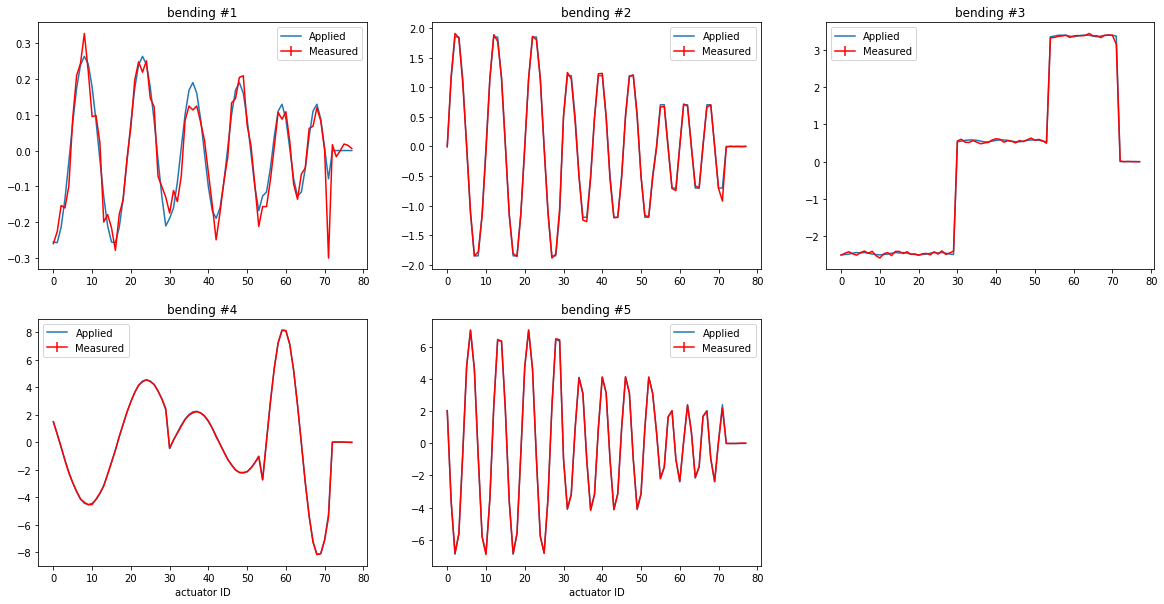

In [68]:
x0 = np.arange(78)
fig, ax = plt.subplots(2,3,figsize=(20,10))
for i in range(5):
    irow = np.int8(i/3)
    icol = np.mod(i,3)
    ax[irow][icol].plot(x0, bm[i,:,0], label='Applied')
    ax[irow][icol].errorbar(x0, np.mean(bm[i,:,1:], axis=1), np.std(bm[i,:,1:], axis=1),color='r', label='Measured')
    ax[irow][icol].set_title('bending #%d'%(i+1))
    ax[irow][icol].legend()
    if irow == 1:
        ax[irow][icol].set_xlabel('actuator ID')
fig.delaxes(ax.flatten()[-1])

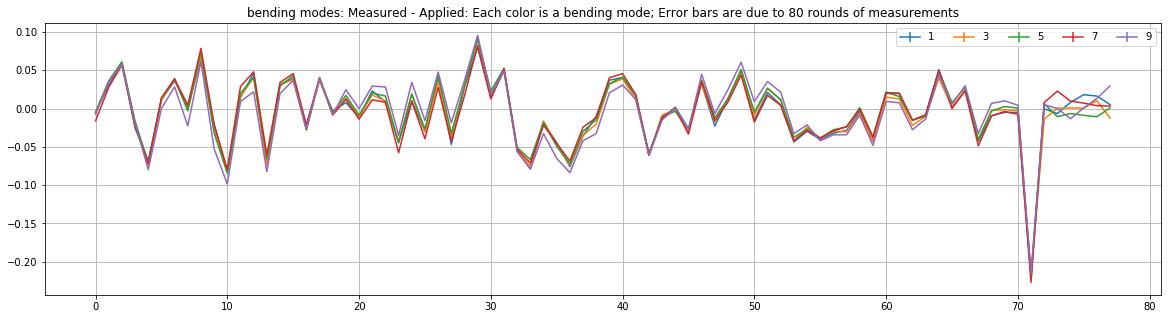

In [73]:
x0 = np.arange(78)
fig, ax = plt.subplots(figsize=(20,5))
for i in range(5):
    aa = bm[i,:,1:] - np.repeat(bm[i,:,0].reshape(-1,1),80, axis=1)
    plt.errorbar(x0, np.mean(aa, axis=1), np.std(aa, axis=1), label='%d'%(2*i+1))
plt.title('bending modes: Measured - Applied: Each color is a bending mode; \
Error bars are due to 80 rounds of measurements');
plt.grid()
plt.legend(ncol=5);

### Final force error by actuator

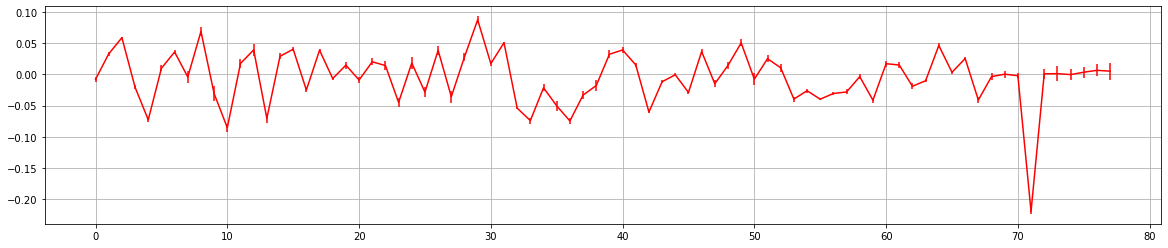

In [74]:
x0 = np.arange(78)
fig, ax = plt.subplots(figsize=(20,4))
aa = bm[:,:,1:]-np.repeat(bm[:,:,0].reshape(5,78,1),80, axis=2)
bb = np.swapaxes(aa,1,2).reshape((-1,78))
plt.errorbar(x0, np.mean(bb, axis=0), np.std(bb, axis=0),color='r')
plt.grid()